# Joint fitting XRT and GBM data with XSPEC models

### Goals

3ML is designed to properly joint fit data from different instruments with thier instrument dependent likelihoods.
We demostrate this with joint fitting data from GBM and XRT while simultaneously showing hwo to use the XSPEC models form **astromodels**

### Setup

You must have you HEASARC initiated so that **astromodels** can find the XSPEC libraries. 




In [2]:
%matplotlib inline
from threeML import *
import os

## Load XRT data

Make a likelihood for the XRT including all the appropriate files

Now using 971 channels out of 1024


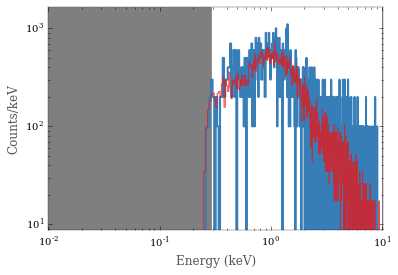

In [3]:
trigger="GRB110731A"
dec=-28.546
ra=280.52
xrt_dir='xrt'
xrt = SwiftXRTLike("XRT",os.path.join(xrt_dir,"xrt_src.pha"),
                   os.path.join(xrt_dir,"xrt_bkg.pha"),
                   os.path.join(xrt_dir,"xrt.rmf"),
                   os.path.join(xrt_dir,"xrt.arf"))

xrt.set_active_measurements("0.3-10.0")
xrt.view_count_spectrum()

## Load GBM data

Load all the GBM data you need and make appropriate background, source time, and energy selections. Make sure to check the light curves! 

In [8]:

gbm_dir=os.path.join('gbm','bn110731A')

# Select the time interval
src_selection = "100.169342-150.169342"

nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(gbm_dir,"glg_tte_n3_bn110731465_v00.fit"),
                         "20-90,160-250", # background selection
                         src_selection,          # source interval
                         rspfile=os.path.join(gbm_dir, "glg_cspec_n3_bn110731465_v00.rsp2"))



Looking for optimal polynomial grade:

delta log-likelihoods:
0 -> 1: delta Log-likelihood = 145.670923776
1 -> 2: delta Log-likelihood = 4.82461856212
2 -> 3: delta Log-likelihood = 0.00878000678495
3 -> 4: delta Log-likelihood = 1.3723357073



View the light curve

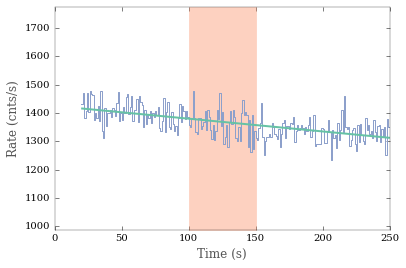

In [9]:
nai3.view_lightcurve(20,250)

Make energy selections and check them out

Now using 120 channels out of 128


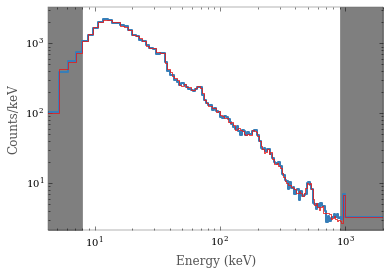

In [10]:
nai3.set_active_measurements("8-900")
nai3.view_count_spectrum()

## Setup the model

**astromodels** allows you to use XSPEC models if you have XSPEC installed.
Set all the normal parameters you would in XSPEC and build a model the normal **3ML/astromodel** way!


In [11]:
xspec_abund('angr')

spectral_model =  XS_phabs()* XS_zphabs() * XS_powerlaw()


spectral_model.nh_1_1=0.101
spectral_model.nh_1_1.fix = True

spectral_model.nh_2_2=0.1114424
spectral_model.nh_2_2.fix = True

spectral_model.redshift_2_2 = 0.618
spectral_model.redshift_2_2.fix =True

In [12]:
spectral_model.display()

* description: ((XS_phabs{1} * XS_zphabs{2}) * XS_powerlaw{3})
  * formula: (no latex formula available)
  * parameters: 
    * nh_1_1: 
      * value: 0.101
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * nh_2_2: 
      * value: 0.1114424
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: 1000000.0
      * unit: 1e+22
      * delta: 0.001
      * free: False
    * redshift_2_2: 
      * value: 0.618
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -0.999
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: False
    * phoindex_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: -3.0
      * max_value: 10.0
      * unit: 
      * delta: 0.01
      * free: True
    * norm_3: 
      * value: 1.0
      * desc: (see https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XspecModels.html)
      * min_value: 0.0
      * max_value: None
      * unit: keV / (cm2 s)
      * delta: 0.1
      * free: True

## Setup the joint likelihood

Create a point source object and model. 

Load the data into a data list and create the joint likelihood


In [13]:
ptsrc = PointSource(trigger,ra,dec,spectral_shape=spectral_model)
model = Model(ptsrc)

data = DataList(xrt,nai3)

jl = JointLikelihood(model, data, verbose=False)
model.display()

name,value,min_value,max_value,unit,delta,free
GRB110731A.spectrum.main.composite.phoindex_3,1.0,-3.0,10.0,,0.01,True
GRB110731A.spectrum.main.composite.norm_3,1.0,0.0,None,keV / (cm2 s),0.1,True


## Fitting

### Maximum Likelihood style

In [14]:
res = jl.fit()

Best fit values:



Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.03 +/- 0.05,
GRB110731A.spectrum.main.composite.norm_3,0.209 +/- 0.008,keV / (cm2 s)



NOTE: errors on parameters are approximate. Use get_errors().

Nuisance parameters:



Name,Value,Unit
InterCalib_of_XRT,1,
InterCalib_of_NAI,1,



Correlation matrix:



1.00,0.60
0.60,1.00



Minimum of -logLikelihood is: 1737.26349199

Contributions to the -logLikelihood at the minimum:



Detector,-LogL
XRT,842.94
NAI3,894.32


In [15]:
res = jl.get_errors()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.03 -0.04 +0.07,
GRB110731A.spectrum.main.composite.norm_3,0.209 -0.009 +0.009,keV / (cm2 s)


 [*********************100%***********************]  completed in 1.4 s

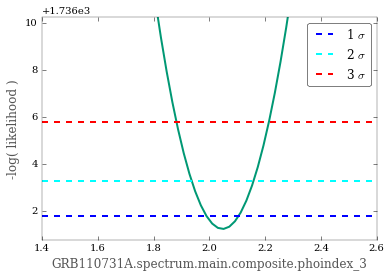

In [16]:
res = jl.get_contours(spectral_model.phoindex_3,1.5,2.5,50)

 [*********************100%***********************]  completed in 4.7 s

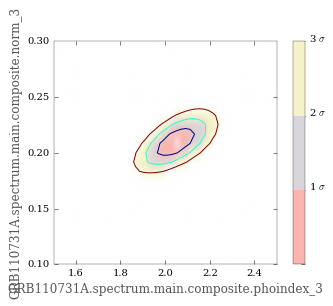

In [17]:
res = jl.get_contours(spectral_model.norm_3,.1,.3,25,spectral_model.phoindex_3,1.5,2.5,50)

### And then go Bayesian!

In [102]:
spectral_model.phoindex_3.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
spectral_model.norm_3.prior = Log_uniform_prior(lower_bound=1E-5, upper_bound=1)

In [106]:
bayes = BayesianAnalysis(model, data)

In [107]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

Running burn-in of 100 samples...

 [*********************100%***********************]  completed in 18.6 s

Sampling...

 [**********************99%***********************]  992 / 1000 in 180.6 s (0:00:01 remaining)
Mean acceptance fraction: 0.71286


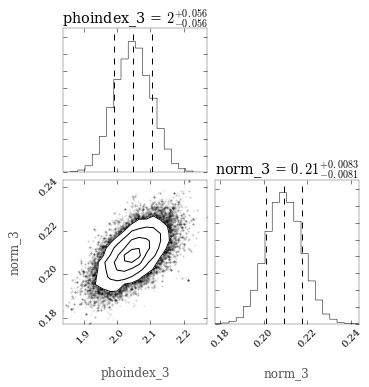

In [108]:
fig = bayes.corner_plot(plot_contours=True, plot_density=False)


In [110]:
bayes.get_highest_density_interval()

Name,Value,Unit
GRB110731A.spectrum.main.composite.phoindex_3,2.05 -0.11 +0.11,
GRB110731A.spectrum.main.composite.norm_3,0.209 -0.016 +0.016,keV / (cm2 s)


OrderedDict([('GRB110731A.spectrum.main.composite.phoindex_3',
              {'lower bound': 1.9420550721054672,
               'median': 2.0473012995313451,
               'upper bound': 2.1563300384857449}),
             ('GRB110731A.spectrum.main.composite.norm_3',
              {'lower bound': 0.19311281485537479,
               'median': 0.20935989107363939,
               'upper bound': 0.22576779703065428})])